In [14]:
import csv
import random
import math
import operator

import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt

In [15]:
stock = 'aapl'

df = pd.read_csv('%s.us.txt' % stock, index_col=0)
df.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
print(df.shape)
df.head()

(8364, 5)


,Open,High,Low,Close,Volume
Date,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062


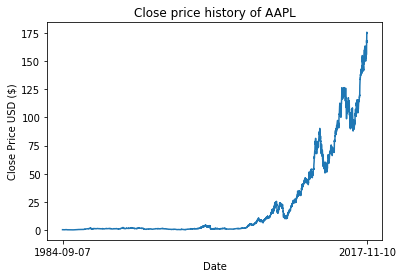

In [16]:
# Visualize closing price history
plt.title('Close price history of %s' % stock.upper())
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.show()

In [17]:
# Create a new column called Next Close, where the value is either up or down depending on the next day's close price compared to today's.
df['Next Day Close'] = np.where(df['Close'] > df['Close'].shift(-1), "Down", "Up")
print(df.shape)
df.head(10)

(8364, 6)


,Open,High,Low,Close,Volume,Next Day Close
Date,,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,Down
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,Up
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,Down
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,Up
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,Up
1984-09-14,0.44052,0.45589,0.44052,0.44566,68847968,Up
1984-09-17,0.45718,0.46357,0.45718,0.45718,53755262,Down
1984-09-18,0.45718,0.46103,0.44052,0.44052,27136886,Down
1984-09-19,0.44052,0.44566,0.43157,0.43157,29641922,Up
